# **IV Surface Modelling**

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
file = "data/intermediate/spx_options_2023_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.35367,0.00,0.00,0.0,0.0,2845.7,2854.60,0.0,0.05
2023-01-04,1200.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,1.17498,2623.64,0.10,1.0,10.0,2643.4,2651.80,0.0,0.05
2023-01-04,1400.0,3853.39,27.0,2023-01-31,1.00000,-0.00031,NaN,1.02388,2377.30,0.07,1.0,2.0,2444.1,2453.70,0.0,0.05
2023-01-04,1500.0,3853.39,27.0,2023-01-31,1.00000,0.00000,NaN,0.95679,0.00,0.10,0.0,1.0,2347.4,2355.90,0.0,0.05
2023-01-04,1600.0,3853.39,27.0,2023-01-31,1.00000,-0.00029,NaN,0.89294,2183.32,0.05,2.0,2.0,2244.6,2253.10,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,5800.0,4772.17,0.0,2023-12-29,0.00084,-0.92248,1.27964,2.46351,0.05,1186.49,5.0,44.0,0.0,0.05,1028.3,1029.90
2023-12-29,5900.0,4772.17,0.0,2023-12-29,0.00027,-0.91952,1.38397,2.68042,0.07,1108.69,3.0,123.0,0.0,0.05,1128.0,1129.30
2023-12-29,6000.0,4772.17,0.0,2023-12-29,0.00026,-0.91572,1.48449,2.91246,0.05,0.00,6.0,0.0,0.0,0.05,1228.0,1229.20


In [ ]:
def compute_iv_smile(options, dte, atm_strike_range=1000):
    options_red = options.loc[options["dte"] == dte].copy()

    atm_idx = (options_red["strike"] - options_red["underlying_last"]).abs().argmin()
    atm_strike = options_red.iloc[atm_idx]["strike"]
    options_red["atm_strike"] = atm_strike

    # Keep only strikes within ±1000 of ATM
    options_red = options_red[((options_red['strike'] - options_red['atm_strike']).abs() <= atm_strike_range)]

    options_red['iv_smile'] = np.where(
        options_red['strike'] < atm_strike,
        options_red['p_iv'],
        np.where(
            options_red['strike'] > atm_strike,
            options_red['c_iv'],
            0.5 * (options_red['c_iv'] + options_red['p_iv'])  # At-the-money
        )
    )
    options_red = options_red.set_index("strike")

    return options_red["iv_smile"]

In [7]:
date = "2023-01-13"
iv_smile = compute_iv_smile(options, date)

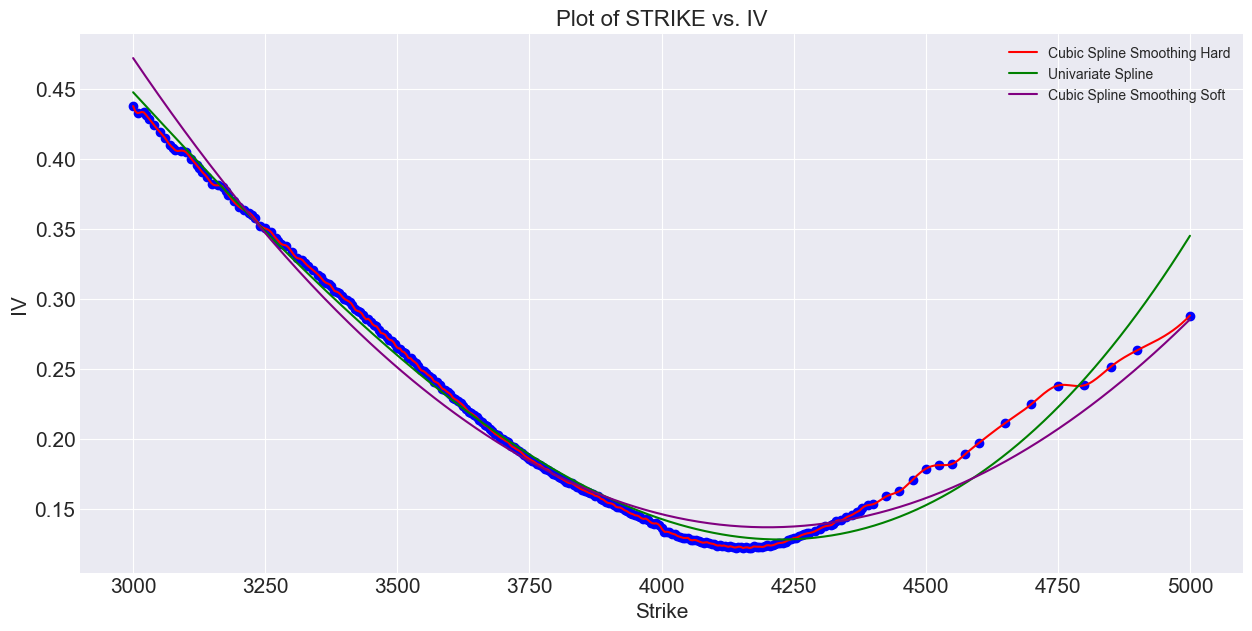

In [ ]:
from scipy.interpolate import UnivariateSpline, CubicSpline

univ_spline = UnivariateSpline(iv_smile.index, iv_smile, s=1)  # s=1 for slight smoothing
cubic_spline_soft = UnivariateSpline(iv_smile.index, iv_smile, k = 2, s=2) 
cubic_spline_hard = CubicSpline(iv_smile.index, iv_smile)

strike_grid = np.linspace(iv_smile.index.min(), iv_smile.index.max(), 500)
iv_smooth_univ = univ_spline(strike_grid)
iv_smooth_cubic_soft = cubic_spline_soft(strike_grid)
iv_smooth_cubic_hard = cubic_spline_hard(strike_grid)


plt.figure(figsize=(15, 7))
plt.scatter(iv_smile.index, iv_smile, color='blue')

plt.plot(strike_grid, iv_smooth_cubic_hard, color='red', label="Cubic Spline Smoothing Hard")
plt.plot(strike_grid, iv_smooth_univ, color='green', label="Univariate Spline")
plt.plot(strike_grid, iv_smooth_cubic_soft, color='purple', label="Cubic Spline Smoothing Soft")

plt.xlabel('Strike', fontsize=15)
plt.ylabel('IV', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.title('Implied Volatility Skew', fontsize=16)
plt.legend()
plt.show()

Here we see the trade-off between overfitting—exemplified by the aggressive cubic spline—and underfitting when using a simplistic univariate spline. The optimal solution lies midway between these two extremes.

## **Construct the IV surface**

In [ ]:
def compute_iv_surface(options):
    surface_data = []

    for (date, expiry), group in options.groupby(["date", "expiry"]):
        smile = compute_iv_smile(group, date)
        for strike, iv in smile.items():
            surface_data.append({
                "date": date,
                "expiry": expiry,
                "dte": group['dte'].iloc[0],
                "strike": strike,
                "iv": iv
            })

    return pd.DataFrame(surface_data)